In [1]:
import matplotlib.pyplot as plt 
plt.style.use('fast')
from pyFTS.partitioners import Grid, CMeans, Entropy
from pyFTS.common import Util as cUtil
from pyFTS.models import hofts,pwfts
from pyFTS.models.multivariate import mvfts, wmvfts, granular, variable
from pyFTS.benchmarks import Measures
from pyFTS.common import Transformations
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime
from pyFTS.common import Membership
import pandas as pd

In [2]:
def init ():
    Dataset = pd.read_csv('./PJME_hourly.csv')
    Dataset.Datetime = pd.to_datetime(Dataset.Datetime)
    Dataset.set_index('Datetime', inplace = True)
    Dataset.rename(columns={'PJME_MW': 'demand'}, inplace=True)
    Dataset = Dataset.resample('H').mean()
    return Dataset

def handleModel(train_set,model):
    plt.figure()
    plt.plot(train_set)
    modelX = cUtil.load_obj(model.name)
    forecasts = modelX.predict(train_set)
    plt.plot(forecasts)
    plt.title(model.name)
    plt.tight_layout()

def createModels(models,train_set,test_set,df):
    for model in models:
        model.fit(train_set, save_model=True, file_path=model.name)
        result = Measures.get_point_statistics(test_set, model)
        dictResult= {   'Name': model.name,
                        'RMSE': result[0],
                        'SMAPE': result[1],
                        'Theils U': result[2]
                    }
        df = df.append(dictResult,ignore_index=True)
        handleModel(model=model, train_set=train_set)
    return df

In [13]:
Dataset = init()
Dataset['weekday'] = Dataset.index.day_name()
Dataset['hour'] = Dataset.index.hour
Dataset = Dataset.resample('D').mean()
Dataset['weekday'] = Dataset.index.day_name()
Dataset.drop(['hour','weekday'],axis=1,inplace=True)

days2predict = 48
train_size = int(len(Dataset["demand"]) - days2predict)
# train_size = int(len(Dataset.demand)*2/3)
train_set_pd = Dataset.demand[:train_size].to_list()
train_set = Dataset.demand[:train_size].to_list()
test_set = Dataset.demand[train_size:]
data = Dataset['demand'].values

/tmp/ipykernel_189224/3464851444.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Dataset = Dataset.resample('D').mean()


/home/cesar/.local/lib/python3.10/site-packages/pyFTS/partitioners/partitioner.py:238: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


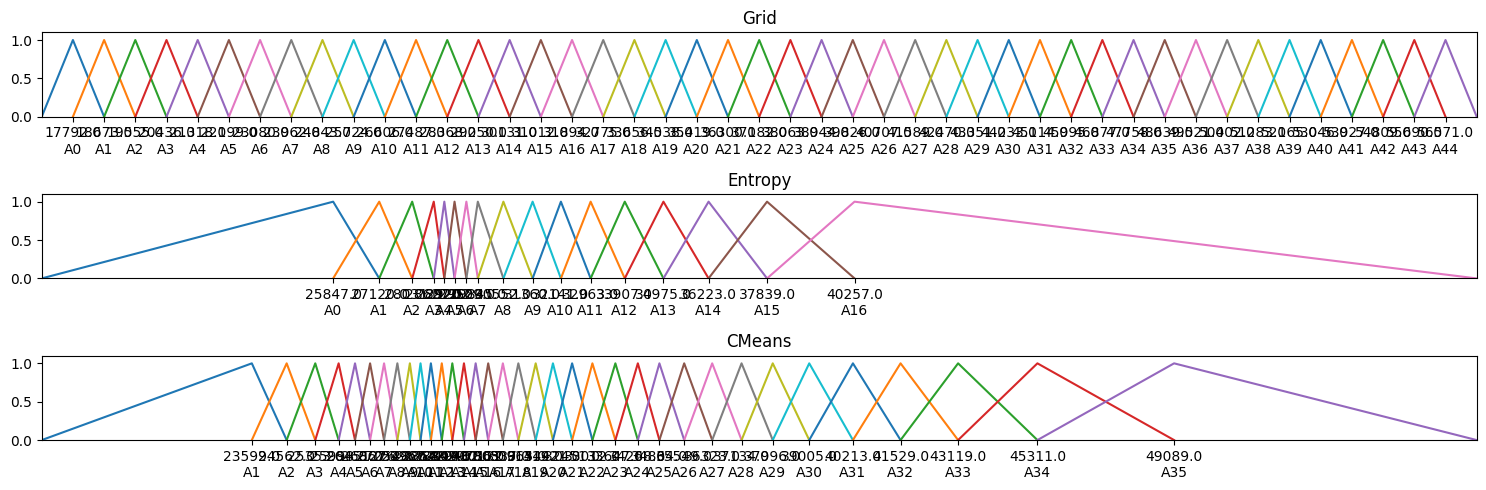

In [21]:
tdiff = Transformations.Differential(1)
partitioner_grid = Grid.GridPartitioner(data=data,npart=45)
partitioner_entropy = Entropy.EntropyPartitioner(data=data,npart=25)
partitioner_cmean = CMeans.CMeansPartitioner(data=data,npart=35)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[15,5])
partitioner_grid.plot(ax[0])
partitioner_entropy.plot(ax[1])
partitioner_cmean.plot(ax[2])
plt.tight_layout()

/tmp/ipykernel_189224/1310585460.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dictResult,ignore_index=True)
/tmp/ipykernel_189224/1310585460.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dictResult,ignore_index=True)
/tmp/ipykernel_189224/1310585460.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dictResult,ignore_index=True)
/tmp/ipykernel_189224/1310585460.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dictResult,ignore_index=True)


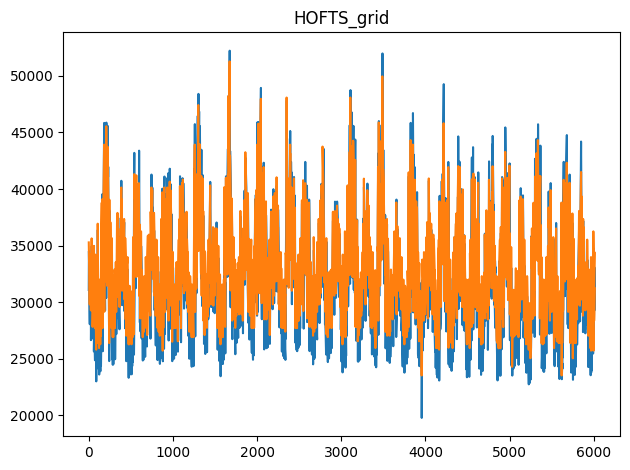

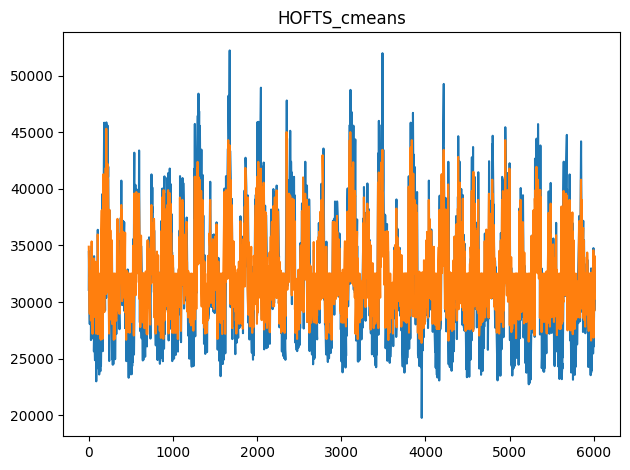

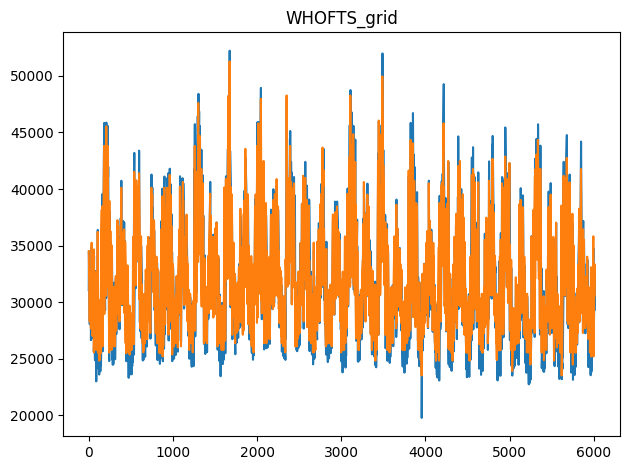

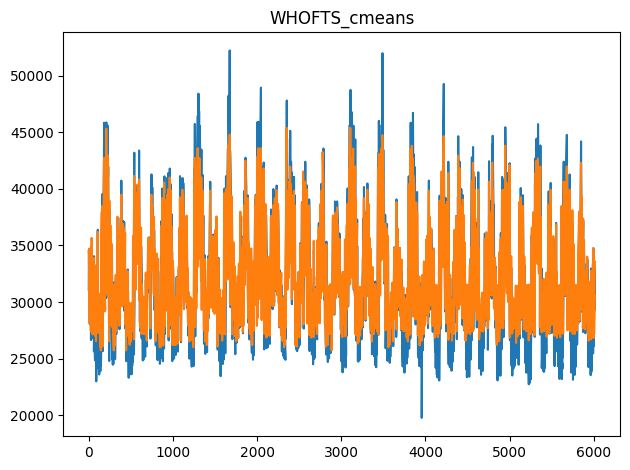

In [22]:
Error_df = pd.DataFrame(columns = ["Name","RMSE","SMAPE","Theils U"])
models=[]

model = hofts.HighOrderFTS(partitioner=partitioner_grid,order=2)
model.name='HOFTS_grid'
models.append(model)

# model = hofts.HighOrderFTS(partitioner=partitioner_entropy,order=2)
# model.name='HOFTS_entropy'
# models.append(model)

model = hofts.HighOrderFTS(partitioner=partitioner_cmean,order=2)
model.name='HOFTS_cmeans'
models.append(model)

model = hofts.WeightedHighOrderFTS(partitioner=partitioner_grid,order=2)
model.name='WHOFTS_grid'
models.append(model)

# model = hofts.WeightedHighOrderFTS(partitioner=partitioner_entropy,order=3)
# model.name='WHOFTS_entropy'
# models.append(model)

model = hofts.WeightedHighOrderFTS(partitioner=partitioner_cmean,order=2)
model.name='WHOFTS_cmeans'
models.append(model)

df = createModels(models=models,train_set=train_set,test_set=test_set,df=Error_df)

In [23]:
print(df.head())

            Name     RMSE  SMAPE  Theils U
0     HOFTS_grid  3147.73   6.71      0.87
1   HOFTS_cmeans  3278.92   6.80      0.92
2    WHOFTS_grid  3297.26   6.84      0.92
3  WHOFTS_cmeans  3286.78   6.99      0.92


In [ ]:
WeightedMVFTS      & 483.25       & 1.15  & 0.30 \\
HOFTS              & 2170.40       & 4.42   \\
MultivariateFTS    & 784.89        & 1.72  & 0.49 \\
Trend Weighted FTS & 1434.53       & 2.44   \\
Granular WMVFTS    & 538.54      & 1.33   & 0.32\\
WHOFTS             & 1121.37       & 2.01   \\
Probabilistic FTS  & 1025.76       & 1.80   \\

& 136.4659
& 138.4793
& 1049.2129